In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [2]:
def draw_edge_pair(x):
    plt.plot([x[0], x[2]], [x[1], x[3]])
    plt.plot([x[4], x[6]], [x[5], x[7]])
    
    
def are_edge_pairs_crossed(p):
    '''
    p - positions of n pairs edges in a [n,8] pytorch tensor, 
        where the postions of 8 nodes come in [ax, ay, bx, by, 
        cx, cy, dy, dy] for the edge pair a-b and c-d.
    
    return - an 1D tensor of boolean values, 
             where True means two edges cross each other. 
    '''
    p1, p2, p3, p4 = p[:,:2], p[:,2:4], p[:,4:6], p[:,6:]
    a = p2 - p1
    b = p3 - p4
    c = p1 - p3
    ax, ay = a[:,0], a[:,1]
    bx, by = b[:,0], b[:,1]
    cx, cy = c[:,0], c[:,1]
    
    denom = ay*bx - ax*by
    numer_alpha = by*cx-bx*cy
    numer_beta = ax*cy-ay*cx
    alpha = numer_alpha / denom
    beta = numer_beta / denom
    return torch.logical_and(
        torch.logical_and(0<alpha, alpha<1),
        torch.logical_and(0<beta, beta<1),
    )



class EdgePairDataset():
    def __init__(self, n=10000):
        super().__init__()
        self.n = n
        self.data = torch.randn(n, 8)
        self.label = are_edge_pairs_crossed(self.data)
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, i):
        return self.data[i], self.label[i]
    
    
    
class CrossingDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_dims = [8,96,256,96,1]
        self.layers = []
        for i, (in_dim, out_dim) in enumerate(zip(self.layer_dims[:-1], self.layer_dims[1:])):
            self.layers.append(nn.Linear(in_dim, out_dim))
            if i < len(self.layer_dims)-2:
                self.layers.append(nn.LeakyReLU())
                self.layers.append(nn.LayerNorm(out_dim))
            else:
                self.layers.append(nn.Sigmoid())
        self.main = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.main(x)
    
    



## Training

In [8]:
dataset = EdgePairDataset(n=int(1e6))
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

device = 'cpu'
model = CrossingDetector().to(device)
bce = nn.BCELoss()
optmizer = optim.SGD(model.parameters(), lr=0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

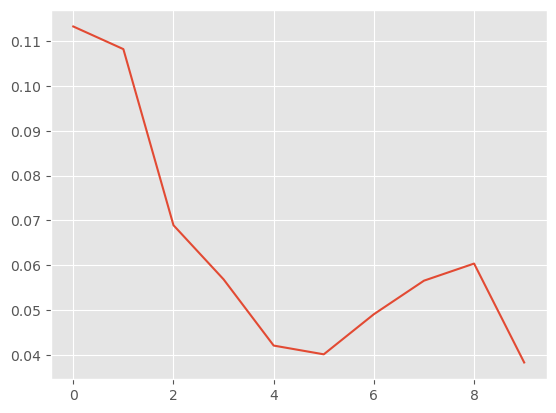

In [10]:


loss_curve = []
for epoch in tqdm(range(10)):
    for edge_pairs, targets in dataloader:
        edge_pairs, targets = edge_pairs.to(device), targets.to(device)
        pred = model(edge_pairs)
        loss = bce(pred, targets.float().view(-1,1))

        optmizer.zero_grad()
        loss.backward()
        optmizer.step()
        
    loss_curve.append(loss.item())
    if epoch % 10 == 9:
        plt.plot(loss_curve)
        plt.show()


## Acurracy

In [16]:
device = 'cpu'
# model = CrossingDetector().to(device)
# model.load_state_dict(torch.load('neural-crossing-detector.pth', map_location=device))

In [18]:
test_loader = DataLoader(EdgePairDataset(n=int(1e4)), batch_size=1024, shuffle=True)

correct = 0
total = 0
with torch.no_grad():
    for edge_pairs, targets in tqdm(test_loader):
        edge_pairs, targets = edge_pairs.to(device), targets.to(device)
        pred = model(edge_pairs)
        correct += ((pred>0.5) == targets.view(-1,1)).sum().item()
        total += len(targets)
        
#         ## vis
#         draw_edge_pair(edge_pairs[0])
#         plt.title(f'{pred[0].item()}/{targets[0].item()}')
#         plt.xlim([0,1])
#         plt.ylim([0,1])
#         plt.show()
print(f'{correct}/{total} {correct/total}')

  0%|          | 0/10 [00:00<?, ?it/s]

9791/10000 0.9791


In [ ]:
# torch.save(model.state_dict(), 'neural-crossing-detector.pth')

## Test: Optimziation on a single pair of crossed edges

In [ ]:
from utils import vis
import random


In [ ]:
from gd2 import GD2
import networkx as nx
import itertools



In [ ]:
import criteria as C

In [ ]:
device = 'cpu'
model = CrossingDetector().to(device)
# model.load_state_dict(torch.load('neural-crossing-detector.pth', map_location=device))



# G = nx.balanced_tree(2,7)
G = nx.grid_2d_graph(20,40)
# G = nx.hypercube_graph(3)
# G = nx.cycle_graph(10)
gd = GD2(G)

## filter out incident edge pairs
edge_pairs = [
    [gd.k2i[e1[0]], gd.k2i[e1[1]], gd.k2i[e2[0]], gd.k2i[e2[1]]] 
    for e1,e2 in itertools.product(G.edges, G.edges) 
    if e1<e2 and len(set(e1).intersection(set(e2)))==0
]

bce_pos = nn.BCELoss(reduction='sum')
bce_nn = nn.BCELoss()

optmizer_nn = optim.SGD(model.parameters(), lr=0.01, momentum=0.1)
optmizer_pos = optim.SGD([gd.pos], lr=0.1, momentum=0.9)
# optmizer_nn = optim.RMSprop(model.parameters(), lr=0.001)
# optmizer_pos = optim.RMSprop([gd.pos], lr=0.1)

dataloader = DataLoader(edge_pairs, batch_size=1024, shuffle=True)

In [ ]:
len(edge_pairs)

In [ ]:
loss_nn_curve, loss_pos_curve = [],[]


#     sample = sum(random.sample(edge_pairs, 16), [])
#     sample = edge_pairs
    
for epoch in tqdm(range(100)):
    for i,sample in tqdm(enumerate(dataloader)):
        sample = torch.stack(sample, 1)
        edge_pair_pos = gd.pos[sample].view(-1,8)
        labels = are_edge_pairs_crossed(edge_pair_pos)

        model.train()
        preds = model(edge_pair_pos.detach().to(device)).view(-1)
        loss_nn = bce_nn(preds, (labels.float()*0.8).to(device))
        optmizer_nn.zero_grad()
        loss_nn.backward()
        optmizer_nn.step()

        model.eval()
        preds = model(edge_pair_pos.to(device)).view(-1)
        loss_pos = (
            bce_pos(preds, (labels.float()*0.1).to(device))
            +0.01*C.vertex_resolution(gd.pos, sampleSize=64)[0]
        )
        optmizer_pos.zero_grad()
        loss_pos.backward()
        optmizer_pos.step()
        if i<100:
    #         loss_nn_curve.append(loss_nn.item())
            loss_pos_curve.append(np.log(loss_pos.item()))


    with torch.no_grad():
        clear_output(wait=True)

        plt.figure(figsize=[16,4])

        plt.subplot(131)
#             plt.plot(loss_nn_curve, label='loss NN')
        plt.plot(loss_pos_curve, label='loss pos')
        plt.legend()

        plt.subplot(132)
        plt.hist([
            preds[labels].cpu().numpy(), 
            preds[~labels].cpu().numpy()], 
            bins=np.linspace(0,1,11), 
            histtype='barstacked'
        )
        plt.title(f'epoch: {epoch}')
        plt.xlim([-0.1, 1.1])
        
        ax = plt.subplot(133)
        pos = gd.pos.detach().numpy()
        pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
        vis.draw_graph(gd.G, pos_G, ax)
        plt.autoscale()

        plt.show()

In [ ]:
C.vertex_resolution(gd.pos, sampleSize=64)

In [ ]:
gd.pos[sample[0:2]]

In [ ]:
labels = are_edge_pairs_crossed(edge_pair_pos)
preds = model(edge_pair_pos.cuda()).detach().cpu().view(-1)
acc = (labels == (preds>0.5)).float().mean()

In [ ]:
acc

In [ ]:
# emin = edge_pair_pos.min(1, keepdim=True).values
# emax = edge_pair_pos.max(1, keepdim=True).values
